In [1]:
%matplotlib notebook

Reviewer 1 suggested an excellent way of testing whether our latency measurements are correct: Turn on the LEDs and detect the turning on using the camera. 

We implemented this by:

    1) At each 50th frame of a trial , turn the red LED on.
    
    2) Take the median of a set of 10 pixels  in the search box and compare the current     intensity to the intensity of the previous frame.
    
    3) If this difference is larger than 2, count consider the LED ‘ON’ as ‘LED ON’ detected and immediately turn the LED off.
    
    4) If the LED has been turned off  in the previous frame, turn the LED on again (this happens only once).

Instead of a real fly (as with Fig1S1b-d) a facsimile (piece of paper) was used at different positions in the frame: Top, center and bottom

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import natsort
import pandas as pd
from pathlib import Path
import os

In [3]:
home_path = os.getcwd()

In [4]:
data_path = Path(home_path, 'data/benchmarking/LED_flash_test/')

target_path = Path(home_path, 'plots/Fig1S1')
os.makedirs(target_path, exist_ok=True)

In [5]:
# This cell extracts the relevant data from the 'LED_flash_test.npy' file

all_time_between_detection = {}
all_time_to_detect_first_flash = {}
all_time_to_detect_second_flash = {}
all_time_between_flashes = {}
all_flash_data = {}

#for j in sorted(data_path.iterdir()):
for j in data_path.iterdir():
    
    if j.is_dir():

        flash = np.load(Path(j, 'LED_flash_test.npy'))
        # TIME.TIME()
        flash[:,2] = flash[:,2] - flash[1,2] # convert from epoch time to time since exp start
        flash[:,2] *= 1000 # convert to miliseconds
        # REAL TIME
        flash[:,3] /= 10e2 # convert to milliseconds

        # Automatic detection of the peaks: 
        # Go through column 1 to detect the peaks where the light is being turned on.
        LED_on = []

        #for i in range(flash.shape[0]):
        #    if flash[i,1] == 1:
        #        LED_on.append(i)
        # then check for each index, how long it takes for the column 0 to also be 1

        LED_2nd_on = []
        #for i in range(flash.shape[0]):
        #    if flash[i,1] == 2:
        #        LED_2nd_on.append(i)
        # then check for each index, how long it takes for the column 0 to also be 1
        first_flash_detected = []
        second_flash_detected = []
        for i in range(flash.shape[0] - 10):
            #print(i)
            if flash[i,1] == 1:
                # This indicates that the LED has been turned on. Append list
                LED_on.append(i)
                # How many frames does it take to detect the flash?
                looking_for_detection = True
                detection_counter = 0
                while looking_for_detection:
                    if flash[i+detection_counter,0] == 1:
                        first_flash_detected.append(i+detection_counter)
                        looking_for_detection = False
                    else:
                        detection_counter += 1

            elif flash[i,1] == 2:
                # This indicates that the LED has been turned on again. Append list
                LED_2nd_on.append(i)
                # How many frames does it take to detect the flash?
                looking_for_detection = True
                detection_counter = 0
                while looking_for_detection:
                    if flash[i+detection_counter,0] == 1:
                        second_flash_detected.append(i+detection_counter)
                        looking_for_detection = False
                    else:
                        detection_counter += 1    
            
        experiment_times = np.zeros((len(LED_on),4))
        for i in range(len(first_flash_detected)):
            experiment_times[i, 0] = flash[first_flash_detected[i], 3]
            experiment_times[i, 1] = flash[second_flash_detected[i], 3]
            experiment_times[i, 2] = flash[LED_on[i], 3]
            experiment_times[i, 3] = flash[LED_2nd_on[i], 3]
        # Time between the two flashes    
        time_between_detection = experiment_times[:,1] - experiment_times[:,0]
        all_time_between_detection[str(j).split('\\')[-1]] = time_between_detection
        
        # Number of frames in time between the two flashes
        time_between_flashes = experiment_times[:,3] - experiment_times[:,2]
        all_time_between_flashes[str(j).split('\\')[-1]] = time_between_flashes
        
        # Time to detect LED flash
        time_to_detect_first_flash = experiment_times[:,0] - experiment_times[:,2]
        all_time_to_detect_first_flash[str(j).split('\\')[-1]] = time_to_detect_first_flash
        
        # Time to detect 2nd LED flash
        time_to_detect_second_flash = experiment_times[:,1] - experiment_times[:,3]
        all_time_to_detect_second_flash[str(j).split('\\')[-1]] = time_to_detect_second_flash
        
        # Keep a copy of the flash data
        all_flash_data[str(j).split('\\')[-1]] = flash

# this is useful to get all the names of the dicts
folders = []
for i in all_time_to_detect_first_flash:
    folders.append(i)

<IPython.core.display.Javascript object>


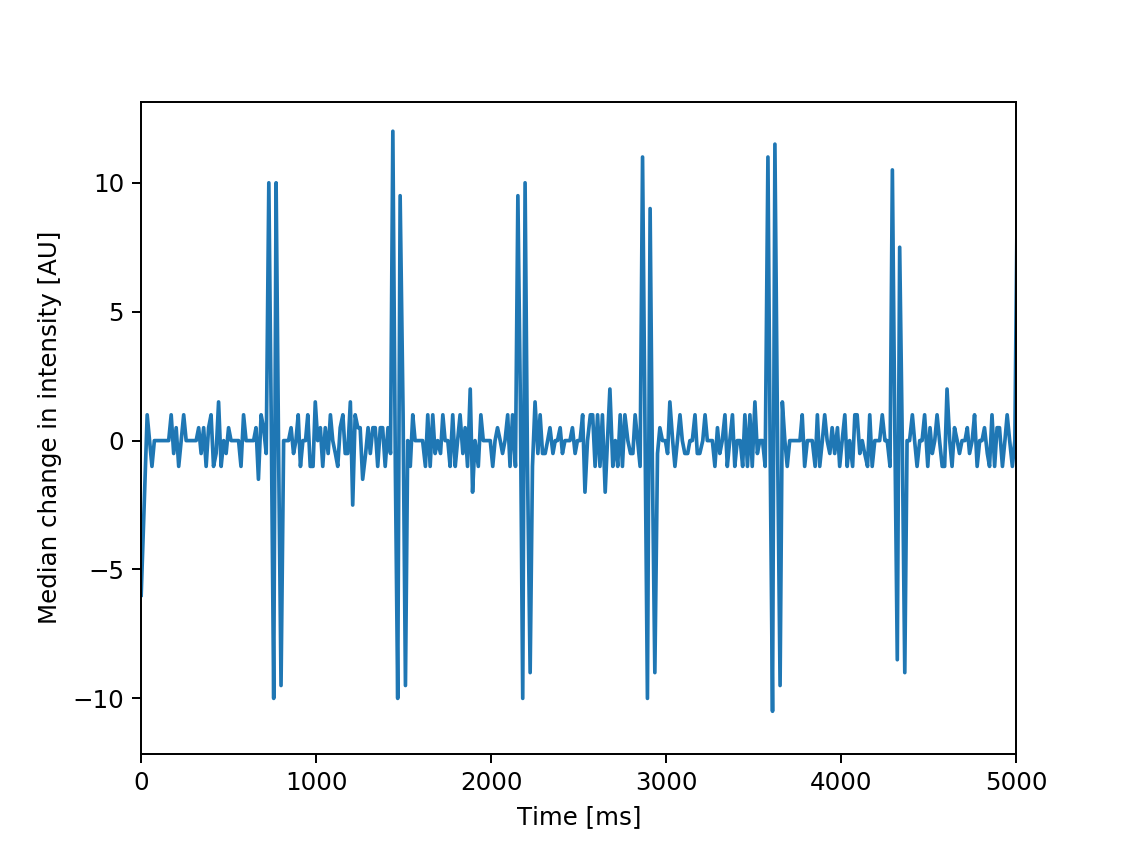

Text(0.5, 0, 'Time [ms]')

In [6]:
# This is a plot of the recorded light intensity changes. It shows that the signal
# is clear and strong
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(all_flash_data[folders[0]][:,2], all_flash_data[folders[0]][:,4])
#ax.plot([0,5000], [2,2])

ax.set_xlim(0,5000)
#ax.set_ylim(-2,13)

ax.set_ylabel('Median change in intensity [AU]')
ax.set_xlabel('Time [ms]')

In [7]:
# used colorbrewer (https://colorbrewer2.org) to select colors with high contrast
colors = ['#1b9e77', '#d95f02', '#7570b3']

In [8]:
def plot(data, save_path):
    """
    This function takes care of plotting
    Uncomment the last line to safe the images
    """
    fig = plt.figure(figsize = (5,3))
    ax = fig.add_subplot(111)
    ax.set_rasterization_zorder(1)
    for counter, folder in enumerate(sorted(data)):
        print(folder)
        #ax.boxplot([all_time_between_flashes[folder]], positions=[counter], showfliers=False)
        x = np.random.normal(counter, 0.03, size=data[folder].shape[0])
        ax.scatter(x, data[folder], alpha = 0.5, zorder=0, color = colors[counter])
    ax.set_xlim(-1, counter+1)
    ax.set_xticks(np.arange(0, counter+1, 1))
    ax.set_xticklabels(['top', 'center', 'bottom'])
    ax.set_yticks((14, 28, 42))
    ax.set_ylim(10,50)

    # get rid of ticks (bottom ticks)
    ax.tick_params(
            #axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            right=False,         # ticks along the left edge are off
            labelleft=True,   # labels along the left edge are off
            labelbottom=True
            ) 

    # turn spines of everywhere except on the left
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(1)
    # modify spines on the left
    ax.spines['left'].set_bounds(14,42)

    # We change the fontsize of minor ticks label 
    ax.tick_params(axis='both', which='major', width=1, length =5)
    #ax.tick_params(axis='both', which='minor', width =2,length =3)
    ax.tick_params(axis='y', labelsize=15)
    
    ax.set_ylabel('Latency [ms]')
    # Uncomment the next line to safe the images
    # fig.savefig(Path(save_path), rasterized=True, dpi=300)

<IPython.core.display.Javascript object>


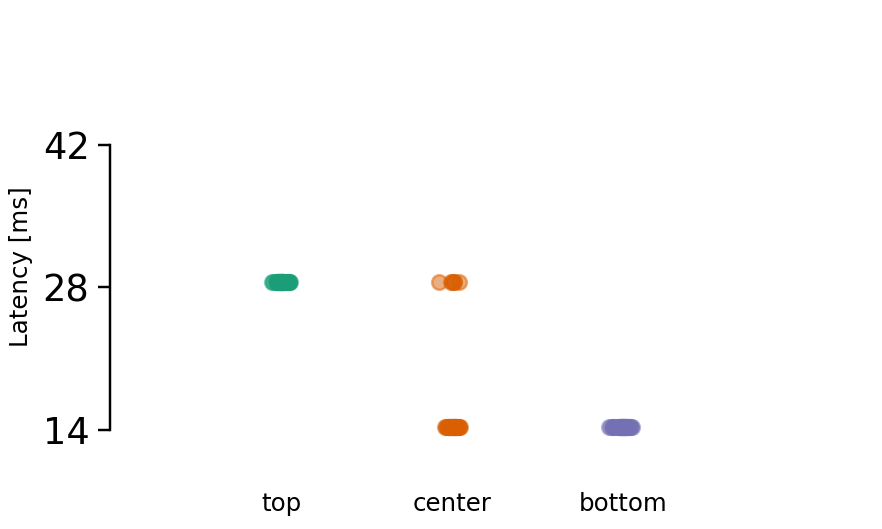

2020.02.23_19-07-20_70fps-larva_mode_top
2020.02.23_19-20-32_70fps-larva_mode_center
2020.02.23_19-34-06_70fps-larva_mode_bottom


In [9]:
plot(all_time_to_detect_first_flash, Path(target_path, 'fig1S1fii.eps'))

<IPython.core.display.Javascript object>


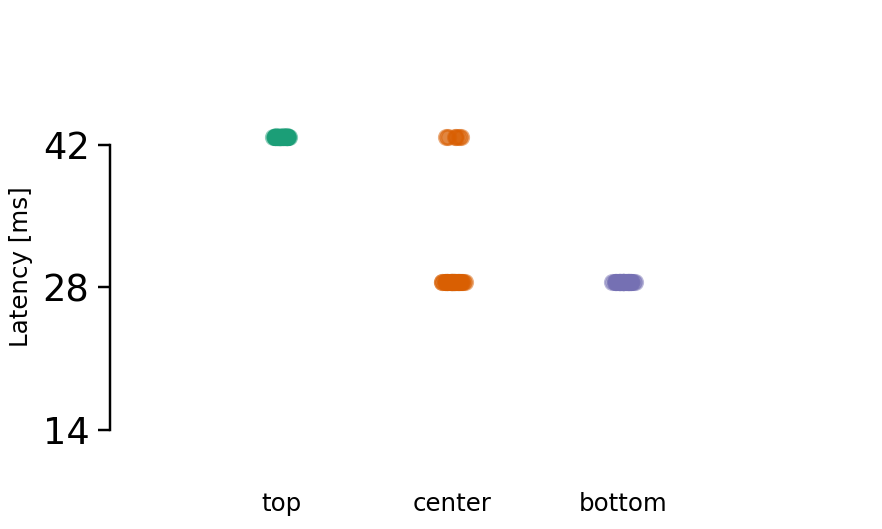

2020.02.23_19-07-20_70fps-larva_mode_top
2020.02.23_19-20-32_70fps-larva_mode_center
2020.02.23_19-34-06_70fps-larva_mode_bottom


In [10]:
plot(all_time_between_flashes, Path(target_path, 'fig1S1fiii.eps'))